# Frequency-Selective AMARES

In *in vivo* Magnetic Resonance Spectroscopy, you often encounter massive confounding signals. For example, in 1H-MRS, the water peak at 4.7 ppm is usually thousands of times larger than the neurochemical peaks (like NAA at 2.0 ppm).

Attempting to fit the entire spectrum simultaneously requires complex baseline modeling and can cause the optimizer to fail. A highly effective strategy is **Frequency-Selective Fitting**. We use a Minimum-Phase Finite Impulse Response (MPFIR) filter to mathematically "cut out" a specific region of interest in the time domain. We then fit only the remaining peaks.

`xmris` makes it incredibly easy to broadcast `pyAMARES`'s 1D filters across N-dimensional data using `xarray`.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Import pyAMARES directly for simulation and filtering tools
import pyAMARES
import xarray as xr
from pyAMARES.libs.MPFIR import MPFIR

# Ensure xmris accessors are registered
import xmris.accessor

## 1. Simulate a Challenging Dataset using pyAMARES
We will use the built-in `pyAMARES.kernel.fid.simulate_fid` function to generate a spectrum containing a massive "Water" peak at 4.7 ppm and a tiny "NAA" peak at 2.0 ppm. We define the true physics using a Ground Truth CSV.

[AMARES | WARNING] Fid is None! Creating unity array instead.
[AMARES | INFO] Checking comment lines in the prior knowledge file


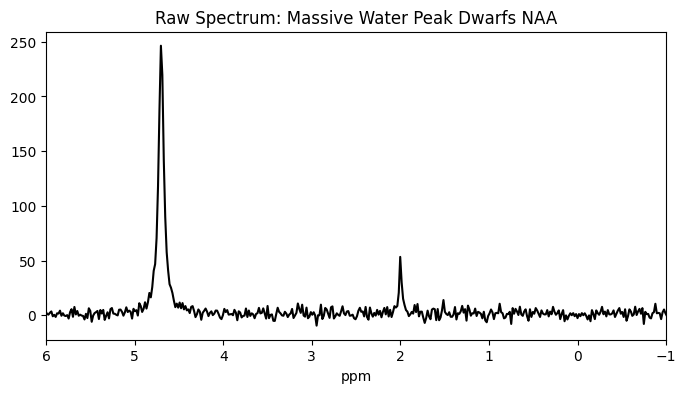

In [2]:
n_points = 1024
sw = 5000.0  # Hz
mhz = 300.0  # 7T 1H
dt = 1.0 / sw
time = np.arange(n_points) * dt

# Define Ground Truth Physics
gt_csv_content = """Index,Water,NAA
Initial Values,,
amplitude,100.0,10.0
chemicalshift,4.7,2.0
linewidth,20.0,10.0
phase,0,0
g,0,0
Bounds,,
amplitude,"(0, ","(0, "
chemicalshift,"(4.6, 4.8)","(1.9, 2.1)"
linewidth,"(5, 50)","(5, 50)"
phase,"(-180, 180)","(-180, 180)"
g,"(0, 1)","(0, 1)"
"""
gt_path = Path("ground_truth.csv")
gt_path.write_text(gt_csv_content)

# Initialize a dummy object just to parse the ground truth parameters
gt_obj = pyAMARES.initialize_FID(
    fid=None,
    priorknowledgefile=str(gt_path),
    MHz=mhz,
    sw=sw,
    deadtime=0.0,
    preview=False,
)

# Use pyAMARES to generate the FID with a target SNR of 20
fid_total = pyAMARES.kernel.fid.simulate_fid(
    gt_obj.initialParams,
    MHz=mhz,
    sw=sw,
    deadtime=0.0,
    fid_len=n_points,
    snr_target=20,
    preview=False,
)

da_raw = xr.DataArray(
    fid_total, dims=["Time"], coords={"Time": time}, attrs={"MHz": mhz, "sw": sw}
)

# Convert to spectrum and assign a ppm coordinate for plotting
spec_raw = da_raw.xmr.to_spectrum()
spec_raw = spec_raw.assign_coords(ppm=spec_raw.coords["Frequency"] / mhz)

# Visualize the problem
fig, ax = plt.subplots(figsize=(8, 4))
spec_raw.real.plot(x="ppm", ax=ax, color="black")
ax.set_xlim(6, -1)
ax.set_title("Raw Spectrum: Massive Water Peak Dwarfs NAA")
plt.show()

## 2. N-Dimensional MPFIR Filtering
We want to isolate the NAA peak. We will define a passband region of `0.0` to `3.5` ppm. Everything outside this region (including the 4.7 ppm water peak) will be filtered out.

We use `xr.apply_ufunc` to apply the `pyAMARES` MPFIR filter. If `da_raw` was a 3D MRSI grid, this code would automatically parallelize the 1D filter across every single voxel!

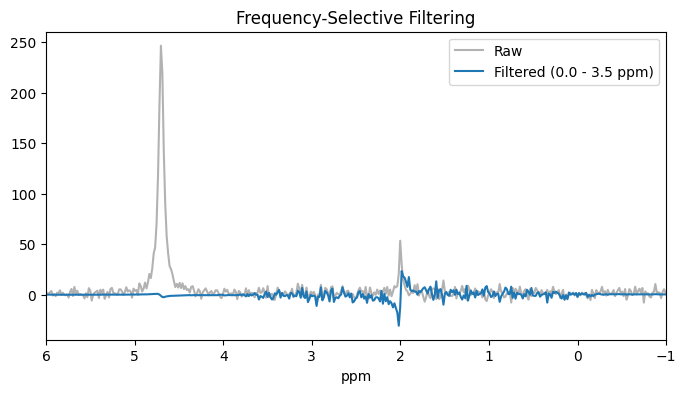

In [3]:
def apply_mpfir_wrapper(fid_1d, dt, mhz, ppm_range):
    """Wrapper function to adapt MPFIR for xarray."""
    return MPFIR(fid_1d, dwelltime=dt, MHz=mhz, ppm_range=ppm_range)


# Broadcast the filter across the DataArray
da_filtered = xr.apply_ufunc(
    apply_mpfir_wrapper,
    da_raw,
    kwargs={"dt": dt, "mhz": mhz, "ppm_range": (0.0, 3.5)},
    input_core_dims=[["Time"]],
    output_core_dims=[["Time"]],
    vectorize=True,  # This enables N-dimensional broadcasting
)

# Preserve the physical attributes!
da_filtered.attrs = da_raw.attrs

# Convert to spectrum and assign ppm coordinates
spec_filtered = da_filtered.xmr.to_spectrum()
spec_filtered = spec_filtered.assign_coords(ppm=spec_filtered.coords["Frequency"] / mhz)

# Visualize the isolated peak
fig, ax = plt.subplots(figsize=(8, 4))
spec_raw.real.plot(x="ppm", ax=ax, color="black", alpha=0.3, label="Raw")
spec_filtered.real.plot(
    x="ppm", ax=ax, color="tab:blue", label="Filtered (0.0 - 3.5 ppm)"
)

ax.set_xlim(6, -1)
ax.set_title("Frequency-Selective Filtering")
ax.legend()
plt.show()

:::{dropdown} What happened to the NAA peak?
If you look closely at the blue line in the plot above, the NAA peak at 2.0 ppm now has a phase shift.

**This is an intentional feature of the MPFIR filter!**

Standard digital filters (like a "zero-phase" filter) preserve the visual shape of a peak, but they do so by smearing the time-domain signal *backward* in time (creating a "pre-echo"). The AMARES algorithm relies on a strict mathematical model: signals are exponentially damped sinusoids that start abruptly at $t=0$ and decay forward. If we smear the signal backward, the AMARES mathematical model completely breaks down.

To solve this, `pyAMARES` uses a **Minimum-Phase** FIR filter. This filter guarantees that all the signal energy remains packed at the very beginning of the FID, preserving the $t=0$ causality required by AMARES.

The mathematical trade-off for preserving this time-domain causality is a strong, frequency-dependent phase shift. The optimizer doesn't mind this at all—it simply fits the `phase` parameter of the NAA peak to ~120 degrees instead of 0 degrees, leaving the crucial `amplitude` (concentration) perfectly accurate!
:::

## 3. Fit the Isolated Peak
Now that the dataset is clean, we only need to provide Prior Knowledge for the single peak we care about! Notice that we leave the phase bounds wide open `(-180, 180)` so the optimizer can capture that MPFIR phase twist.

In [4]:
# Simple PK file for NAA only
pk_csv_content = """Index,NAA
Initial Values,
amplitude,10.0
chemicalshift,2.0
linewidth,10.0
phase,0
g,0
Bounds,
amplitude,"(0, "
chemicalshift,"(1.8, 2.2)"
linewidth,"(2, 30)"
phase,"(-180, 180)"
g,0
"""

pk_path = Path("selective_pk.csv")
pk_path.write_text(pk_csv_content)

# Fit the filtered DataArray using xmris
ds_fit = da_filtered.xmr.fit_amares(
    prior_knowledge_file=pk_path, method="least_squares"
)

Auto-selected FID index 0 for initialization(SNR: 5.11)
[AMARES | INFO] Checking comment lines in the prior knowledge file
[AMARES | WARNING] There is no styled_df!
[AMARES | WARNING] There is no simple_df!
[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
[AMARES | INFO] It seems that zeros are padded after 974
[AMARES | INFO] Remove padded zeros from residual estimation!
[AMARES | INFO] 
    Lmfit Fitting Results:
    ----------------
    Number of function evaluations (nfev): 10
    Reduced chi-squared (redchi): 2.8106158513762316
    Fit success status: Success
    Fit message: Both `ftol` and `xtol` termination conditions are satisfied.
[AMARES | INFO] Norm of residual = 5744.899
[AMARES | INFO] Norm of the data = 13737.040
[AMARES | INFO] resNormSq / dataNormSq = 0.418
[AMARES | INFO] Fitting 1 spectra with 4 processors took 1 seconds


### Evaluate the Fit
Because the water peak was mathematically removed in the time-domain, the AMARES optimizer easily locks onto the NAA peak without any baseline distortion.

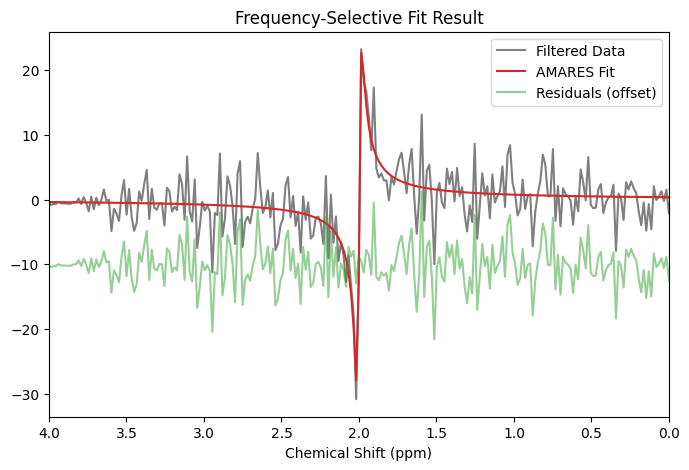

In [5]:
spec_filtered_data = ds_fit.raw_data.xmr.to_spectrum()
spec_fit_data = ds_fit.fit_data.xmr.to_spectrum()
spec_res_data = ds_fit.residuals.xmr.to_spectrum()

# Assign ppm coordinates
spec_filtered_data = spec_filtered_data.assign_coords(
    ppm=spec_filtered_data.coords["Frequency"] / mhz
)
spec_fit_data = spec_fit_data.assign_coords(ppm=spec_fit_data.coords["Frequency"] / mhz)
spec_res_data = spec_res_data.assign_coords(ppm=spec_res_data.coords["Frequency"] / mhz)

fig, ax = plt.subplots(figsize=(8, 5))

# Plot Real parts
ax.plot(
    spec_filtered_data.coords["ppm"],
    spec_filtered_data.real,
    color="black",
    alpha=0.5,
    label="Filtered Data",
)
ax.plot(
    spec_fit_data.coords["ppm"], spec_fit_data.real, color="tab:red", label="AMARES Fit"
)
ax.plot(
    spec_res_data.coords["ppm"],
    spec_res_data.real - 10,
    color="tab:green",
    alpha=0.5,
    label="Residuals (offset)",
)

ax.set_xlim(4, 0)  # Zoom into the NAA region in ppm!
ax.set_title("Frequency-Selective Fit Result")
ax.set_xlabel("Chemical Shift (ppm)")
ax.legend()
plt.show()

### Restoring the Visual Phase
As explained above, the MPFIR filter twisted the phase of our NAA peak. However, because AMARES fit the `phase` as a free parameter, it successfully quantified exactly *how much* it was twisted!

We can extract that fitted phase from our `Dataset` and use the `.xmr.phase()` accessor to apply the inverse zero-order phase correction (`p0`). This will "untwist" the data, restoring the beautiful absorptive Lorentzian peak for our final visualization.

The MPFIR filter twisted the phase by: -96.88 degrees


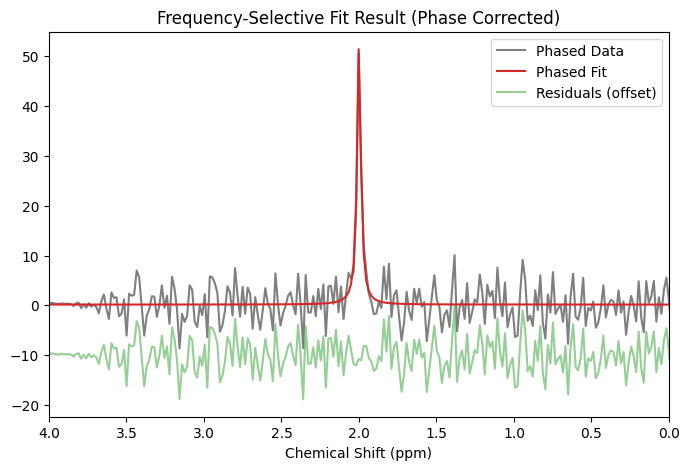

In [6]:
# 1. Extract the fitted phase for the NAA peak (in degrees)
fitted_naa_phase = ds_fit.phase.sel(Metabolite="NAA").values.item()
print(f"The MPFIR filter twisted the phase by: {fitted_naa_phase:.2f} degrees")

# 2. Apply the inverse phase correction to all spectra using the xmris accessor
phased_filtered = spec_filtered_data.xmr.phase(p0=-fitted_naa_phase)
phased_fit = spec_fit_data.xmr.phase(p0=-fitted_naa_phase)
phased_res = spec_res_data.xmr.phase(p0=-fitted_naa_phase)

# 3. Plot the beautifully phased results!
fig, ax = plt.subplots(figsize=(8, 5))

# Plot Real parts
ax.plot(
    phased_filtered.coords["ppm"],
    phased_filtered.real,
    color="black",
    alpha=0.5,
    label="Phased Data",
)
ax.plot(phased_fit.coords["ppm"], phased_fit.real, color="tab:red", label="Phased Fit")
ax.plot(
    phased_res.coords["ppm"],
    phased_res.real - 10,
    color="tab:green",
    alpha=0.5,
    label="Residuals (offset)",
)

ax.set_xlim(4, 0)  # Zoom into the NAA region in ppm
ax.set_title("Frequency-Selective Fit Result (Phase Corrected)")
ax.set_xlabel("Chemical Shift (ppm)")
ax.legend()
plt.show()

In [7]:
# CRITICAL ASSERTIONS FOR NBMAKE CI
# 1. Check Dataset generation
assert isinstance(ds_fit, xr.Dataset)
assert "amplitude" in ds_fit.data_vars

# 2. Check Fit Accuracy (Did it recover the ~10.0 amplitude?)
fitted_naa_amp = ds_fit.amplitude.sel(Metabolite="NAA").values.item()
np.testing.assert_allclose(
    fitted_naa_amp,
    10.0,
    rtol=0.2,
    err_msg="Selective fitting failed to recover NAA amplitude",
)

# Cleanup
gt_path.unlink(missing_ok=True)
pk_path.unlink(missing_ok=True)